In [1]:
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from ic_course_utils import replace_tag
from ic_course_utils import create_hits_animation
from ic_course_utils import sphere

%matplotlib inline

In [2]:
input_file = "data/HEe_fastsim.sophronia.h5"
#input_file = "data/HEe_fullsim.sophronia.h5"

# Input file structure

The input file contains a table at `/RECO/Events` that holds a hit collection for each event.
Each row contains a single hit.

The table contains the following columns:
- event: event number
- time: timestamp of the event in s
- npeak: index of the S2 peak within the event
- Xpeak: global X position of the S2 peak
- Ypeak: global Y position of the S2 peak
- nsipm: number of sipms with signal (always 1, will be dropped in the future)
- X, Y: x-y position of the SiPM
- Xrms, Yrms: always NaN (will be dropped in the future)
- Z: drift distance in mm
- Q: SiPM charge in pes
- E: corresponding fraction of the slice energy calculated as $\frac{Q_i}{\sum Q_i}$ 
- Q: corrected SiPM charge (deprecated, may be removed in the future)
- E: corrected hit energy
- track_id: deprecated (will be removed in the future)
- Ep: deprecated (will be removed in the future)

In [3]:
!ptdump -v $input_file:/RECO/Events

/RECO/Events (Table(3182,)shuffle, zlib(4)) 'Hits'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "time": Float64Col(shape=(), dflt=0.0, pos=1),
  "npeak": UInt16Col(shape=(), dflt=0, pos=2),
  "Xpeak": Float64Col(shape=(), dflt=0.0, pos=3),
  "Ypeak": Float64Col(shape=(), dflt=0.0, pos=4),
  "nsipm": UInt16Col(shape=(), dflt=0, pos=5),
  "X": Float64Col(shape=(), dflt=0.0, pos=6),
  "Y": Float64Col(shape=(), dflt=0.0, pos=7),
  "Xrms": Float64Col(shape=(), dflt=0.0, pos=8),
  "Yrms": Float64Col(shape=(), dflt=0.0, pos=9),
  "Z": Float64Col(shape=(), dflt=0.0, pos=10),
  "Q": Float64Col(shape=(), dflt=0.0, pos=11),
  "E": Float64Col(shape=(), dflt=0.0, pos=12),
  "Qc": Float64Col(shape=(), dflt=0.0, pos=13),
  "Ec": Float64Col(shape=(), dflt=0.0, pos=14),
  "track_id": Int32Col(shape=(), dflt=0, pos=15),
  "Ep": Float64Col(shape=(), dflt=0.0, pos=16)}
  byteorder := 'little'
  chunkshape := (546,)
  autoindex := True
  colindexes := {
    "event": Index(6, mediumshu

# Input file data visualization

hDSTs are read directly as pandas DataFrames:

In [4]:
dst = pd.read_hdf(input_file, "/RECO/Events")
dst

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,26,5.348394e+06,0,139.067634,87.195110,1,125.0,85.0,0.0,0.0,91.281375,7.088914,135.941661,-1.0,0.000507,-1,-1.0
1,26,5.348394e+06,0,139.067634,87.195110,1,125.0,95.0,0.0,0.0,91.281375,11.436635,219.316396,-1.0,0.000831,-1,-1.0
2,26,5.348394e+06,0,139.067634,87.195110,1,135.0,75.0,0.0,0.0,91.281375,8.759229,167.972701,-1.0,0.000631,-1,-1.0
3,26,5.348394e+06,0,139.067634,87.195110,1,135.0,85.0,0.0,0.0,91.281375,35.520828,681.170645,-1.0,0.002621,-1,-1.0
4,26,5.348394e+06,0,139.067634,87.195110,1,135.0,95.0,0.0,0.0,91.281375,33.907310,650.228772,-1.0,0.002552,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3177,117,1.812015e+07,0,-3.181583,97.555456,1,5.0,115.0,0.0,0.0,337.576844,8.783311,336.500956,-1.0,0.001332,-1,-1.0
3178,117,1.812015e+07,0,-3.181583,97.555456,1,15.0,95.0,0.0,0.0,337.576844,9.287977,355.835431,-1.0,0.001371,-1,-1.0
3179,117,1.812015e+07,0,-3.181583,97.555456,1,15.0,105.0,0.0,0.0,337.576844,10.526705,403.292821,-1.0,0.001574,-1,-1.0
3180,117,1.812015e+07,0,-3.181583,97.555456,1,15.0,115.0,0.0,0.0,337.576844,6.177336,236.662412,-1.0,0.000936,-1,-1.0


hDSTs with Kr are not very interesting. For a more interesting output see the last section in the Sophronia notebook.

In [5]:
from invisible_cities.reco.xy_algorithms import barycenter

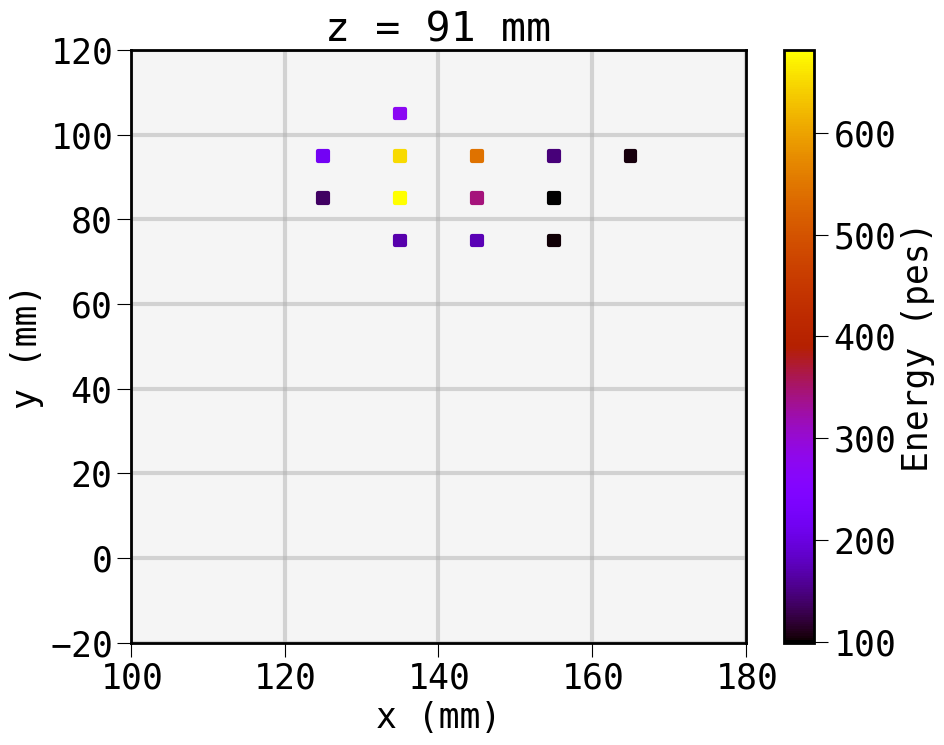

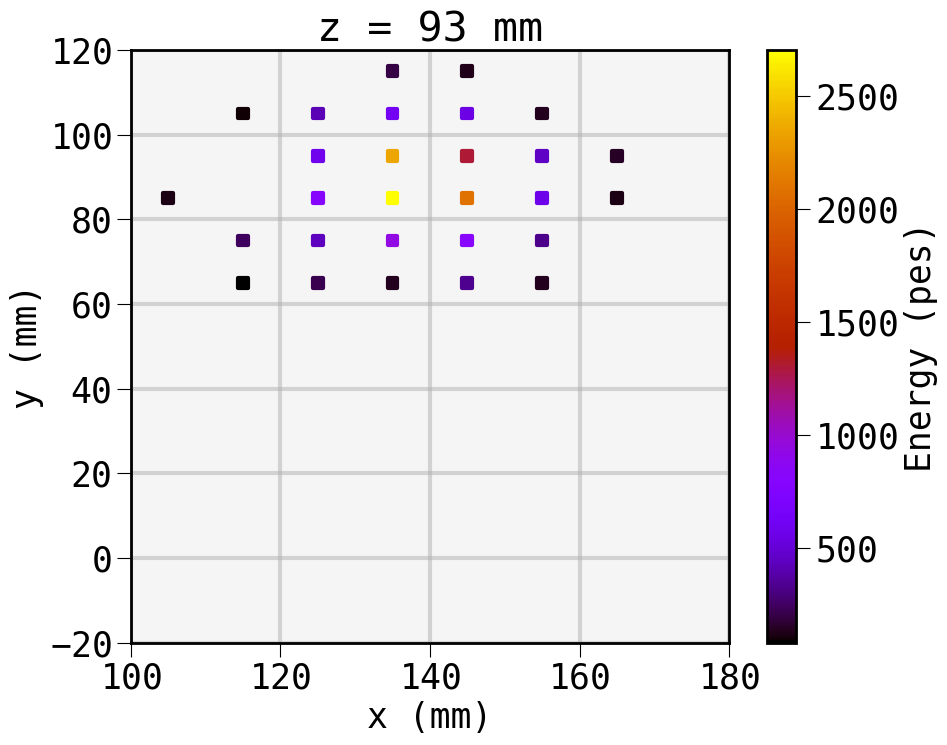

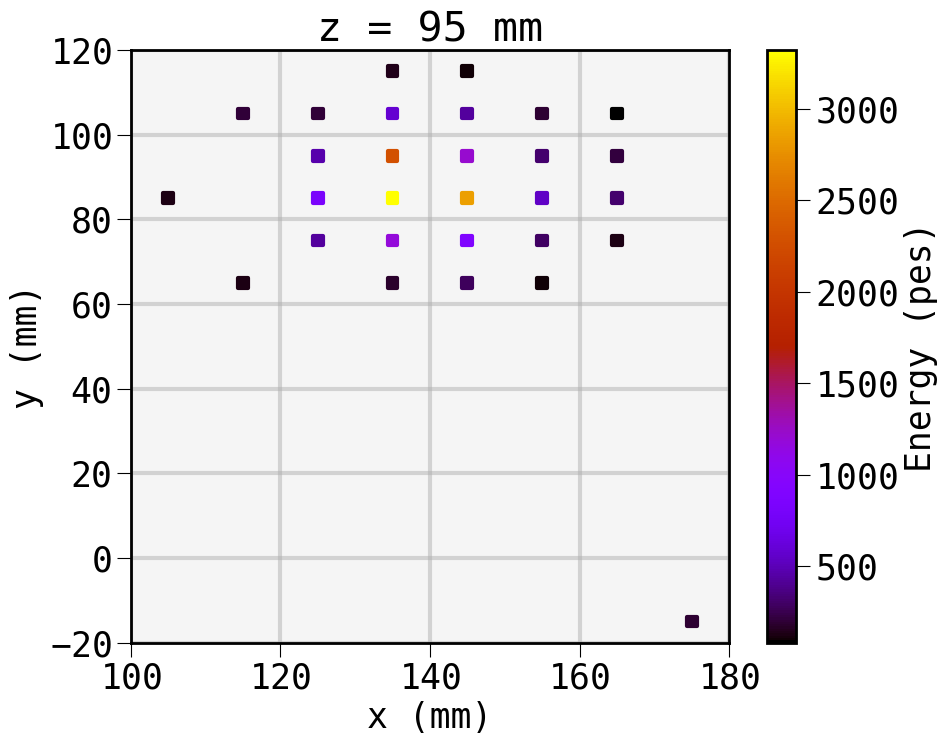

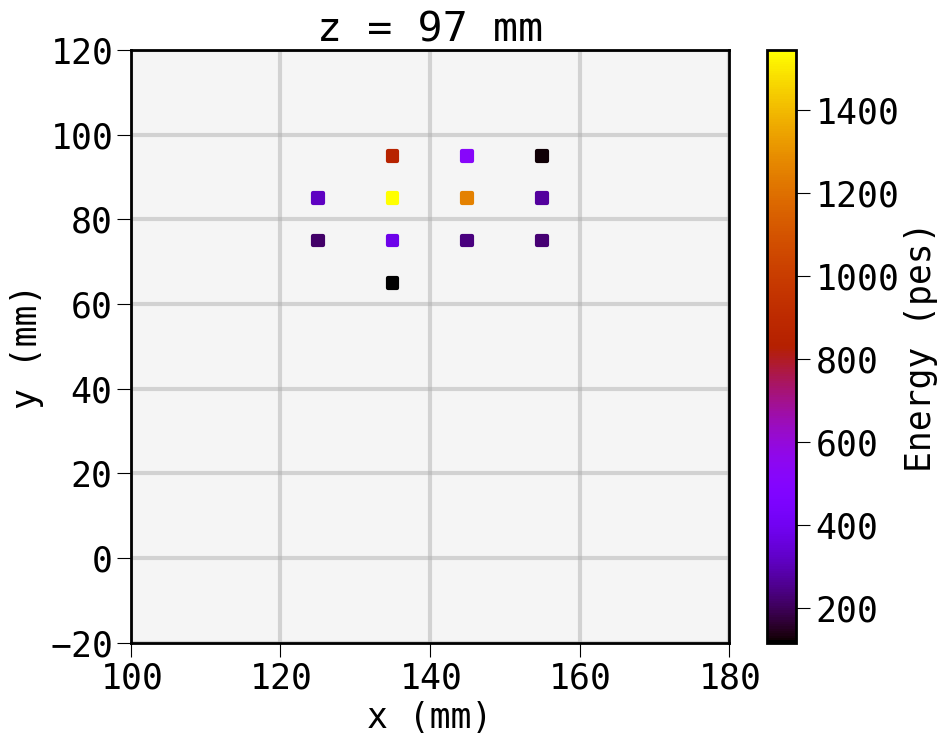

In [6]:
event = dst.event.iloc[0]
peak  = 0
all_hits  = dst.loc[lambda df: (df.event == event) & (df.npeak == peak)]
for z, hits in all_hits.groupby("Z"):
    if len(hits) <= 3: continue
    plt.figure(figsize=(10,8))
    plt.scatter(hits.X, hits.Y, marker="s", s=50, c=hits.E)
    plt.gca().set_facecolor("whitesmoke")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.title(f"z = {z:.0f} mm")
    plt.xlim(all_hits.X.min() - 5, all_hits.X.max() + 5)
    plt.ylim(all_hits.Y.min() - 5, all_hits.Y.max() + 5)
    plt.colorbar().set_label("Energy (pes)")

Animation.save using <class 'matplotlib.animation.HTMLWriter'>
Disabling savefig.bbox = 'tight', as it may cause frame size to vary, which is inappropriate for animation.


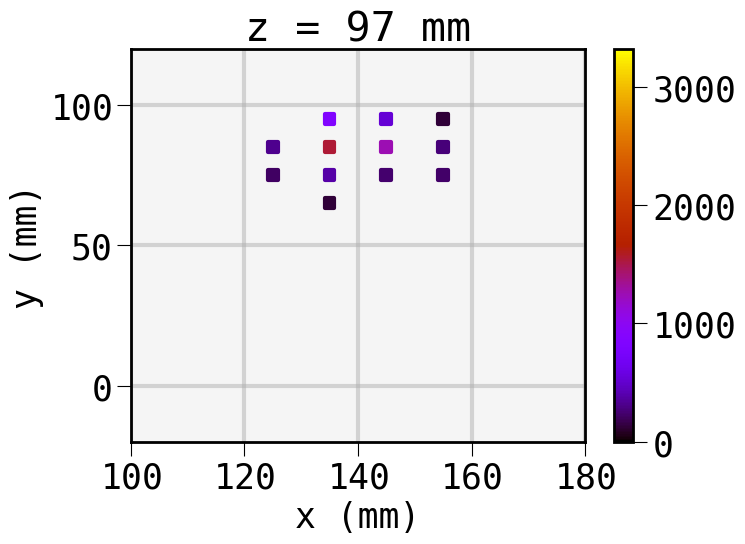

In [7]:
create_hits_animation(all_hits, hitsize=50)

# Esmeralda

## Description

Produces voxels and connects them to find tracks.

This city reads hDSTs produced by Sophronia and produces tracks and corrected hits. It also produces a summary of the event topology and copies the kDST from the input to the output file. The steps performed by Esmeralda are:
- Apply geometrical and lifetime corrections
- Fiducialize hits: remove external hits that cannot be corrected accurately
- Apply a high charge threshold to the input hits (\*). If this leaves behind a slice with no hits, a fake hit (NN-hit) is temporarily created.
- Merge NN-hits: The NN-hits' energy is reassigned to the closest non-NN-hits
- Voxelizes surviving hits
- Finds tracks by optimizing the path that connects all voxels
- Drops low energy voxels in the track extrema
- Obtains the blobs energy by integrating the energy is a certain radius around the end
- Produces a topology summary of the event

(\*) This removes peripheral hits, leaving only the skeleton of the electron trajectory

More details will be found in the official documentation:
https://next-exp-sw.readthedocs.io/en/latest/esmeralda.html
.

## Parameters

| Parameter | Type  | Description |
|:--------:|:--------:|:--------:|
| `threshold` | `float` | Charge threshold applied to the hits |
| `same_peak` | `bool` | Whether to allow the NN hits' energy reassignment to hits in other S2 peaks |
| `fiducial_r` | `float` | Radius for hit fiducialization |
| `paolina_params` | `dict` | Parameters to configure the track-finding algorithm |
| `corrections_file` | `str` | Filename containing the correction maps |
| `apply_temp` | `bool` | Whether to apply temporal corrections (always False for MC) |

Paolina params:

| Parameter | Type  | Description |
|:--------:|:--------:|:--------:|
| `vox_size` | `(float, float, float) ` | (Maximum) size of voxels |
| `strict_voxel_size` | `bool` | Whether to allow  event-wise adaptative voxel size |
| `energy_threshold` | `float` | Energy threshold for voxel-dropping at the extremes (in energy units, not pes) |
| `min_voxels` | `int` | Minimum number of voxels for for track reconstruction |
| `blob_radius` | `float` | Integration radius to obtain blob energies |
| `max_num_hits` | `int` | Maximum number of hits to attempt reconstruction (\*) |

(\*) Sometimes we record spurious events with an unphysical number of hits. These can make the program effectively hang, so we discard them for topological reconstruction.

## Configuration

An Esmeralda configuration file for NEW data.

Note that here we don't specify the input and output files in the config file, but you can do so!

In [8]:
config_file = "config_files/esmeralda.conf"

In [9]:
!cat $config_file

event_range = all
compression = "ZLIB4"
print_mod   = 1

detector_db = "new"
run_number = -6400

threshold = 15 * pes
same_peak = True

fiducial_r = 200 * mm

paolina_params      = dict(
   vox_size         = [10 * mm, 10 * mm, 10 * mm],
   strict_vox_size  = True,
   energy_threshold = 10 * keV,
   min_voxels       = 4,
   blob_radius      = 21 * mm,
   max_num_hits     = 10000)

## City execution

In [10]:
output_file = replace_tag(input_file, "sophronia", "esmeralda")
output_file

'data/HEe_fastsim.esmeralda.h5'

In [11]:
!city esmeralda $config_file -i $input_file -o $output_file

NumExpr defaulting to 4 threads.
Using selector: EpollSelector
events processed: 0, event number: 26
events processed: 1, event number: 39
events processed: 2, event number: 65
events processed: 3, event number: 78
events processed: 4, event number: 104
events processed: 5, event number: 117


## Output

- cDST (`CHITS/highTh`): same as hDST, but contain a corrected-energy field and are associated to tracks
- tracks (`Tracking/Tracks`): a table of track properties. Each row is a track in an event
- summary (`Summary/Events`): a table holding basic event properties
- kDST (`DST/Events`): copied from input

The cDST table contains the following columns:
- event: event number
- time: timestamp of the event in s
- npeak: index of the S2 peak within the event
- Xpeak: global X position of the S2 peak
- Ypeak: global Y position of the S2 peak
- nsipm: number of sipms with signal (always 1, will be dropped in the future)
- X, Y: x-y position of the SiPM
- Xrms, Yrms: always NaN (will be dropped in the future)
- Z: drift distance in mm
- Q: SiPM charge in pes
- E: corresponding fraction of the slice energy calculated as $\frac{Q_i}{\sum Q_i}$ 
- Q: corrected SiPM charge (deprecated, may be removed in the future)
- E: corrected hit energy
- track_id: track index the hit belongs to
- Ep: hit energy used for tracking (\*)

The tracks table contains the following columns:
- event: event number
- trackID: track index
- energy: total track energy
- length: track length
- numb_of_voxels: number of voxels associated to the track
- numb_of_hits: number of hits associated to the track
- numb_of_tracks: number of tracks in the event
- x/y/z_min; max x/y/z coordinate in the hit collection of the track
- x/y/z_max: max x/y/z coordinate in the hit collection of the track
- x/y/z/r_ave: average x/y/z/r coordinate in the hit collection of the track
- extreme1_x/y/z: x/y/z coordinate of one extreme
- extreme2_x/y/z: x/y/z coordinate of the other extreme
- blob1_x/y/z: x/y/z coordinate of the lower energy blob
- blob2_x/y/z: x/y/z coordinate of the higher energy blob
- eblob1: energy of the lower energy blob
- eblob2: energy of the higher energy blob
- ovlp_blob_energy: whether the two blobs overlap, sharing part of the energy
- vox_size_x/y/z: voxel size along the x/y/z axis

The summary table contains the following columns:
- event: event number
- evt_energy: total event energy (including all tracks)
- evt_charge: total event charge (including all tracks)
- evt_ntrks: number of tracks in the event
- evt_nhits: number of hits in the event
- evt_x/y/z/r_avg: average x/y/z/r position of all hits
- evt_x/y/z/r_min: minimum x/y/z/r position of all hits
- evt_x/y/z/r_max: maximum x/y/z/r position of all hits
- evt_out_of_map: whether this events contains hits that could not be corrected properly

(\*) Since the track-finding algorithm has a threshold on voxels, some hits might redistribute their energy. This field contains this new energy distribution

In [12]:
!ptdump -v $output_file:/CHITS/highTh
!ptdump -v $output_file:/Summary/Events
!ptdump -v $output_file:/Tracking/Tracks

/CHITS/highTh (Table(1255,)shuffle, zlib(4)) 'Hits'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "time": Float64Col(shape=(), dflt=0.0, pos=1),
  "npeak": UInt16Col(shape=(), dflt=0, pos=2),
  "Xpeak": Float64Col(shape=(), dflt=0.0, pos=3),
  "Ypeak": Float64Col(shape=(), dflt=0.0, pos=4),
  "nsipm": UInt16Col(shape=(), dflt=0, pos=5),
  "X": Float64Col(shape=(), dflt=0.0, pos=6),
  "Y": Float64Col(shape=(), dflt=0.0, pos=7),
  "Xrms": Float64Col(shape=(), dflt=0.0, pos=8),
  "Yrms": Float64Col(shape=(), dflt=0.0, pos=9),
  "Z": Float64Col(shape=(), dflt=0.0, pos=10),
  "Q": Float64Col(shape=(), dflt=0.0, pos=11),
  "E": Float64Col(shape=(), dflt=0.0, pos=12),
  "Qc": Float64Col(shape=(), dflt=0.0, pos=13),
  "Ec": Float64Col(shape=(), dflt=0.0, pos=14),
  "track_id": Int32Col(shape=(), dflt=0, pos=15),
  "Ep": Float64Col(shape=(), dflt=0.0, pos=16)}
  byteorder := 'little'
  chunkshape := (546,)
  autoindex := True
  colindexes := {
    "event": Index(6, mediumsh

All these tables are read directly as pandas DataFrames:

In [13]:
chits   = pd.read_hdf(output_file, "/CHITS/highTh")
summary = pd.read_hdf(output_file, "/Summary/Events")
tracks  = pd.read_hdf(output_file, "/Tracking/Tracks")

tracks

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,26,0,0.619973,165.850575,69,156,3,5.0,-65.0,237.918531,...,301.421279,5.000000,5.000000,243.958844,0.146565,0.061976,0.000000,10.0,10.0,10.0
1,26,1,0.182684,24.142136,6,21,3,135.0,75.0,91.281375,...,93.558746,135.000000,75.000000,94.221223,0.168353,0.156643,0.142312,10.0,10.0,10.0
2,26,2,0.060028,14.142136,4,12,3,-135.0,-5.0,318.988281,...,320.191874,-125.000000,5.000000,320.244120,0.060028,0.060028,0.060028,10.0,10.0,10.0
3,39,0,0.549455,123.424168,45,157,3,-15.0,-15.0,112.142875,...,114.314874,5.000000,35.000000,187.128732,0.116579,0.069320,0.000000,10.0,10.0,10.0
4,39,1,0.201436,58.783152,16,33,3,5.0,-15.0,237.904281,...,268.209392,45.000000,25.000000,237.904281,0.052798,0.045114,0.000000,10.0,10.0,10.0
5,39,2,0.078272,14.142136,3,9,3,25.0,25.0,205.907844,...,212.826790,25.000000,35.000000,207.397983,0.078272,0.078272,0.078272,10.0,10.0,10.0
6,65,0,0.664831,75.604779,42,171,2,-15.0,-45.0,308.991906,...,369.746199,25.000000,-35.000000,310.902411,0.122231,0.099955,0.000000,10.0,10.0,10.0
7,65,1,0.123622,17.320508,5,15,2,5.0,-25.0,270.864906,...,282.848718,5.000000,-5.000000,272.439656,0.086998,0.063196,0.026572,10.0,10.0,10.0
8,78,0,0.612524,51.462644,39,124,4,-85.0,-5.0,148.242219,...,190.692361,-45.000000,8.699003,154.684022,0.237186,0.114406,0.000000,10.0,10.0,10.0
9,78,1,0.154670,58.783152,12,19,4,-45.0,-25.0,229.895500,...,230.948395,-5.000000,5.000000,265.872094,0.071485,0.044257,0.000000,10.0,10.0,10.0


## Track visualization

### 3D

In [14]:
%matplotlib notebook

<IPython.core.display.Javascript object>


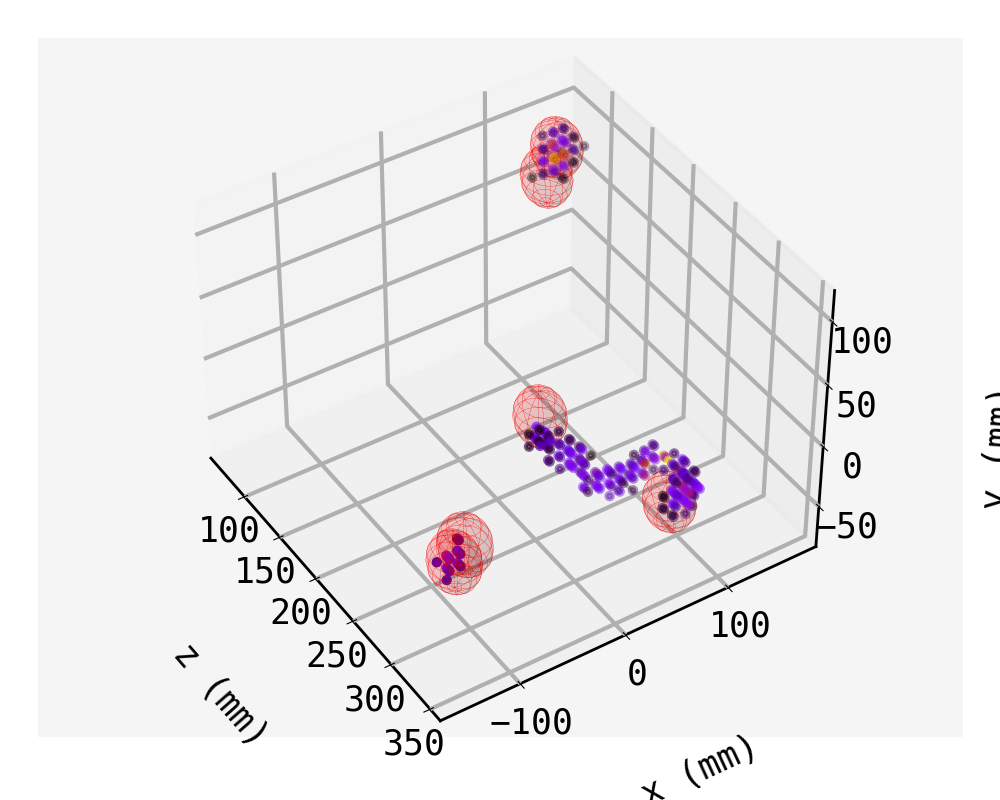

In [15]:
event = chits.event.unique()[0]
peak  = 0
rblob = 21 # mm
hits  = chits .loc[lambda df: (df.event == event)]
trks  = tracks.loc[lambda df: (df.event == event)]

plt.ion()

ax = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
ax.scatter(hits.Z, hits.X, hits.Y, c=hits.Ec)
ax.set_facecolor("whitesmoke")
ax.set_xlabel("z (mm)", labelpad=50)
ax.set_ylabel("x (mm)", labelpad=50)
ax.set_zlabel("y (mm)", labelpad=50)
for _, trk in trks.iterrows():
    sphere(ax, trk.extreme1_z, trk.extreme1_x, trk.extreme1_y, rblob)
    sphere(ax, trk.extreme2_z, trk.extreme2_x, trk.extreme2_y, rblob)
plt.show()

# Notes